In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
import pickle
import os

In [4]:
np.random.seed(42)

In [128]:
data = pd.read_csv("../data/formatted_ed2022.csv")

C:\Users\priya\AppData\Local\Temp\ipykernel_36424\1934294881.py:1: DtypeWarning: Columns (88,133,298,393,397,401,405,413,417,421,425,432,433,436,437,440,441,443,444,445,452,453,456,457,460,461,464,465,472,473,476,477,480,481,484,485,492,493,496,497,500,501,503,504,505,512,513,516,517,520,521,523,524,525,532,533,536,537,540,541,543,544,545,552,553,556,557,560,561,563,564,565,571,572,573,575,576,577,579,580,581,583,584,585,591,592,595,596,599,600,603,604,611,612,615,616,619,620,622,623,624,631,635,639,643,651,652,655,656,659,660,662,663,671,672,675,676,679,680,682,683,684,686,687,688,689,690,691,692,694,695,696,698,699,700,702,703,704,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,725,726,727,728,729,730,731,732,734,735,736,738,739,740,742,743,744,746,747,748,749,750,751,752,754,755,756,758,759,760,762,763,764,766,767,768,769,770,771,772,774,775,776,778,779,780,782,783,784,786,787,788,789,790,791,792,794,795,796,798,799,800,802,803,806,807,808,809,810,811,814,815

In [129]:
# Record triage level 1 as level 2, since the paper shows that the model cannot distinguish between these levels
data.loc[data['IMMEDR'] == 'Immediate', 'IMMEDR'] = 'Emergent'

In [130]:
# Impute or drop missing or null values
data = data[~((data['ARREMS'] == 'Blank') | (data['ARREMS'] == 'Unknown'))]
data = data[~(data['INJPOISAD'] == 'Blank')]

data.loc[data['TOTDIAG'] == "'None' box and all item fields are blank", 'TOTDIAG'] = 0
data.loc[data['TOTPROC'] == "'None' box and all item fields are blank", 'TOTPROC'] = 0
data.loc[data['DRUGID1'] == '', 'DRUGID1'] = 'NONE'
data.loc[data['DRUGID2'] == '', 'DRUGID2'] = 'NONE'
data.loc[data['DRUGID3'] == '', 'DRUGID3'] = 'NONE'
data.loc[data['DRUGID4'] == '', 'DRUGID4'] = 'NONE'
data.loc[data['AGE'] == 'Under one year', 'AGE'] = 0
data.loc[data['AGE'] == '94 years and over', 'AGE'] = 94

data['ARREMS'] = data['ARREMS'].map({'Yes': 1, 'No': 0})

In [131]:
data.shape

(9932, 913)

In [132]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data.drop('IMMEDR', axis=1), data[['IMMEDR']], test_size=0.023, random_state=42)

In [133]:
train_X['IMMEDR'] = train_y
train_X.to_csv('train.csv', index=False)
test_X['IMMEDR'] = test_y
test_X.to_csv('test.csv', index=False)

In [134]:
train_X = pd.read_csv('train.csv')
test_X = pd.read_csv('test.csv')
train_y = train_X['IMMEDR']
test_y = test_y['IMMEDR']

C:\Users\priya\AppData\Local\Temp\ipykernel_36424\2681720337.py:1: DtypeWarning: Columns (391,392,395,396,399,400,403,404,412,416,420,424,431,432,435,436,439,440,443,444,451,452,455,456,459,460,463,464,471,472,475,476,479,480,483,484,491,492,495,496,499,500,503,504,511,512,515,516,519,520,522,523,524,531,532,535,536,539,540,542,543,544,551,552,555,556,559,560,562,563,564,571,572,575,576,579,580,582,583,584,590,591,594,595,598,599,602,603,610,611,614,615,618,619,622,623,630,634,638,642,650,651,654,655,658,659,662,670,671,674,675,678,679,681,682,683,690,691,694,695,698,699,702,703,710,711,712,714,715,716,718,719,720,722,724,730,731,734,735,738,739,741,742,743,745,746,747,748,749,750,751,753,754,755,757,758,759,761,762,763,765,766,767,768,769,770,771,773,774,775,777,778,779,781,782,783,785,786,787,788,789,790,791,793,794,795,797,798,799,801,802,805,806,807,808,809,810,813,814,817,818,821,825,826,827,828,829,830,831,832,833,834,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,85

In [135]:
features = ['TOTDIAG', 'RFV1', 'ARREMS', 'DRUGID1', 'RFV2', 'CAUSE1', 'RFV3', 'DRUGID2', 'DRUGID4', 'AGE', 'DRUGID3', 'INTENT15', 'INJPOISAD', 'INJURY72', 'TOTPROC']
train_X = train_X[features]
test_X = test_X[features]

In [137]:
train_X.dtypes

TOTDIAG       int64
RFV1         object
ARREMS        int64
DRUGID1      object
RFV2         object
CAUSE1       object
RFV3         object
DRUGID2      object
DRUGID4      object
AGE           int64
DRUGID3      object
INTENT15     object
INJPOISAD    object
INJURY72     object
TOTPROC       int64
dtype: object

In [138]:
# Encode categorical variables
categorical_cols = train_X.select_dtypes(include=['object', 'category']).columns.tolist()

In [139]:
train_X_encoded = pd.get_dummies(train_X, columns=categorical_cols, drop_first=True)
test_X_encoded = pd.get_dummies(test_X, columns=categorical_cols, drop_first=True)

In [140]:
train_X_encoded.shape

(9703, 3271)

In [141]:
test_X_encoded.shape

(229, 538)

In [142]:
aligned_test_X_encoded = test_X_encoded.copy()
for col in set(train_X_encoded.columns) - set(test_X_encoded.columns):
    if pd.api.types.is_numeric_dtype(train_X_encoded[col]):
        aligned_test_X_encoded[col] = 0
    elif pd.api.types.is_bool_dtype(train_X_encoded[col]):
        aligned_test_X_encoded[col] = False
    else:
        aligned_test_X_encoded[col] = ""

aligned_test_X_encoded = aligned_test_X_encoded.drop(columns=list(set(test_X_encoded.columns) - set(train_X_encoded.columns)), errors='ignore')
aligned_test_X_encoded = aligned_test_X_encoded[train_X_encoded.columns]

C:\Users\priya\AppData\Local\Temp\ipykernel_36424\4247479450.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aligned_test_X_encoded[col] = 0
C:\Users\priya\AppData\Local\Temp\ipykernel_36424\4247479450.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aligned_test_X_encoded[col] = 0
C:\Users\priya\AppData\Local\Temp\ipykernel_36424\4247479450.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns a

In [143]:
train_X_encoded.shape

(9703, 3271)

In [144]:
aligned_test_X_encoded.shape

(229, 3271)

In [145]:
dt_model = DecisionTreeClassifier(
    criterion='entropy',
    min_samples_leaf=5,
    min_impurity_decrease=0.001,
    class_weight='balanced',
    random_state=42
)

In [146]:
dt_model.fit(train_X_encoded, train_y)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       min_impurity_decrease=0.001, min_samples_leaf=5,
                       random_state=42)

In [147]:
y_pred = dt_model.predict(aligned_test_X_encoded)

In [148]:
# Calculate metrics
accuracy = accuracy_score(test_y, y_pred)
conf_matrix = confusion_matrix(test_y, y_pred)
kappa = cohen_kappa_score(test_y, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Kappa: {kappa:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(test_y, y_pred))

Accuracy: 0.4279
Kappa: 0.2353

Confusion Matrix:
[[34  1  2  7]
 [ 1  0  2  1]
 [ 5 20 30  7]
 [41 19 25 34]]

Classification Report:
              precision    recall  f1-score   support

    Emergent       0.42      0.77      0.54        44
   Nonurgent       0.00      0.00      0.00         4
 Semi-urgent       0.51      0.48      0.50        62
      Urgent       0.69      0.29      0.40       119

    accuracy                           0.43       229
   macro avg       0.41      0.39      0.36       229
weighted avg       0.58      0.43      0.45       229



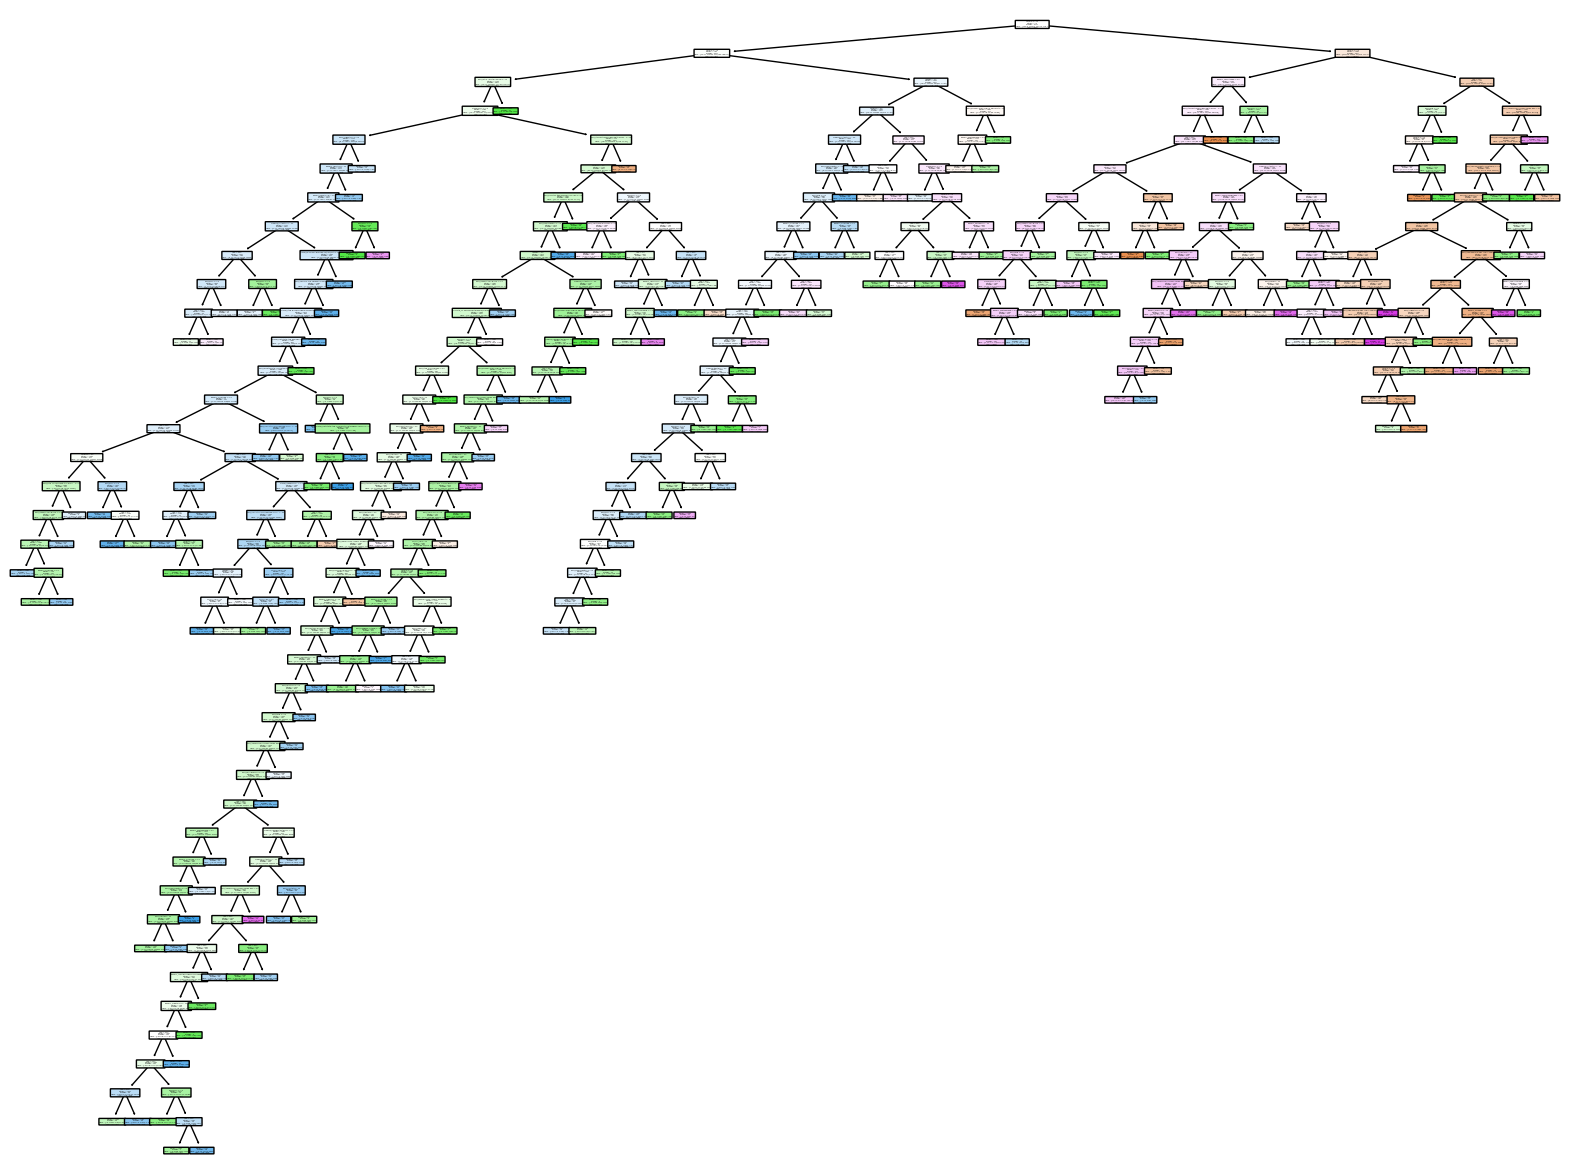

In [149]:
# Visualize the tree
plt.figure(figsize=(20, 15))
plot_tree(dt_model, feature_names=train_X_encoded.columns, filled=True, 
          rounded=True, class_names=[str(c) for c in dt_model.classes_])
plt.savefig('decision_tree.png')

In [150]:
def check_feature_usage(dt_model, X_train, original_features, categorical_features):
    """
    Check which original features were used in the decision tree after encoding.
    
    Args:
        dt_model: Trained decision tree model
        X_train: Encoded training features
        original_features: List of original feature names (before encoding)
        categorical_features: List of categorical features that were encoded
    
    Returns:
        Lists of used and unused original features
    """
    # Get the features actually used in the tree
    used_indices = dt_model.tree_.feature[dt_model.tree_.feature != -2]
    used_encoded_columns = set([X_train.columns[i] for i in used_indices])
    
    # Track which original features are used
    used_original_features = set()
    
    # For each original feature
    for feature in original_features:
        if feature in categorical_features:
            # Check if any encoded column from this feature was used
            prefix = f"{feature}_"
            feature_columns = [col for col in X_train.columns if col.startswith(prefix)]
            
            if any(col in used_encoded_columns for col in feature_columns):
                used_original_features.add(feature)
        else:
            # For non-categorical features, check directly
            if feature in used_encoded_columns:
                used_original_features.add(feature)
    
    # Find which original features were completely unused (winnowed)
    unused_original_features = set(original_features) - used_original_features
    
    return list(used_original_features), list(unused_original_features)

features = ['TOTDIAG', 'RFV1', 'ARREMS', 'DRUGID1', 'RFV2', 'CAUSE1', 'RFV3', 'DRUGID2', 'DRUGID4', 'AGE', 'DRUGID3', 'INTENT15', 'INJPOISAD', 'INJURY72', 'TOTPROC']
categorical_features = ['RFV1', 'DRUGID1', 'RFV2', 'CAUSE1', 'RFV3', 'DRUGID2', 'DRUGID4', 'DRUGID3', 'INTENT15', 'INJPOISAD', 'INJURY72']

used_features, winnowed_features = check_feature_usage(dt_model, train_X_encoded, features, categorical_features)

print(f"\nOriginal features used in the decision tree: {len(used_features)} of {len(features)}")
for i, feature in enumerate(used_features, 1):
    print(f"{i}. {feature}")

print(f"\nOriginal features completely 'winnowed out': {len(winnowed_features)}")
for i, feature in enumerate(winnowed_features, 1):
    print(f"{i}. {feature}")


Original features used in the decision tree: 14 of 15
1. RFV2
2. INTENT15
3. RFV1
4. TOTPROC
5. CAUSE1
6. INJPOISAD
7. ARREMS
8. AGE
9. DRUGID3
10. TOTDIAG
11. INJURY72
12. RFV3
13. DRUGID2
14. DRUGID1

Original features completely 'winnowed out': 1
1. DRUGID4


In [151]:
import numpy as np
from scipy.stats import entropy

def calculate_tree_entropy_metrics(dt_model, X, y):
    """
    Calculate various entropy metrics for a decision tree model.
    """
    # Initial entropy (before any tree splits)
    classes, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    initial_entropy = entropy(probs)
    
    # Node entropies from the trained tree
    node_impurities = dt_model.tree_.impurity
    n_nodes = dt_model.tree_.node_count
    
    # Get leaf nodes entropy
    leaf_mask = dt_model.tree_.children_left == -1
    leaf_impurities = node_impurities[leaf_mask]
    avg_leaf_entropy = np.mean(leaf_impurities)
    
    # Decision node entropy (non-leaf nodes)
    decision_mask = ~leaf_mask
    decision_impurities = node_impurities[decision_mask]
    avg_decision_entropy = np.mean(decision_impurities) if len(decision_impurities) > 0 else 0
    
    # Prediction entropy
    y_pred_proba = dt_model.predict_proba(X)
    pred_entropies = np.array([entropy(probs) for probs in y_pred_proba])
    avg_prediction_entropy = np.mean(pred_entropies)
    
    # Calculate weighted average leaf entropy 
    # (weighted by number of samples in each leaf)
    n_samples_leaves = dt_model.tree_.n_node_samples[leaf_mask]
    weighted_leaf_entropy = np.sum(leaf_impurities * n_samples_leaves) / np.sum(n_samples_leaves)
    
    return {
        'initial_entropy': initial_entropy,
        'avg_leaf_entropy': avg_leaf_entropy,
        'avg_decision_entropy': avg_decision_entropy,
        'avg_prediction_entropy': avg_prediction_entropy,
        'weighted_leaf_entropy': weighted_leaf_entropy,
        'entropy_reduction': initial_entropy - weighted_leaf_entropy
    }

# Usage in your code:
# After fitting the model
entropy_metrics = calculate_tree_entropy_metrics(dt_model, aligned_test_X_encoded, test_y)

print("\nEntropy Metrics:")
for metric, value in entropy_metrics.items():
    print(f"{metric}: {value:.4f}")


Entropy Metrics:
initial_entropy: 1.0815
avg_leaf_entropy: 1.0941
avg_decision_entropy: 1.6188
avg_prediction_entropy: 0.8741
weighted_leaf_entropy: 1.2438
entropy_reduction: -0.1623
